<h1><center>Deep Learning Project: Neural Image Captioning</center></h1>
<h2><center>Part I: simple CNN-RNN-based architecture<center><h2>

**Authors**: Ryan Boustany, Emma Sarfati  
**Teacher**: Marco Cuturi  
Deep Learning Course - ENSAE 3rd year  
$\texttt{ryan.boustany@ensae.fr}$ ⎜ $\texttt{emma.sarfati@ensae.fr}$

<h1><center>Abstract</center></h1>
    
In this project, we aim at using deep learning for generating automatic caption of an image. Recent works have imposed deep learning as indispensable tool for image processing but also for natural language processing tasks. Image Captioning is a specific task that gathers both of the spirits; on the one hand, the image processing part deals with capturing the best features of an image. On the other hand, the caption generation part must link the visual features to the language ones. Hence, it is indispensable to use an architecture that takes as input image features, and outputs a sentence, *i.e* a encoded vectors of words. In this notebook, we propose a CNN-RNN based architecture to treat the images/captions sets of inputs at the same time. Our model is pretty basic and far from the state-of-the-art results; however, for academic purpose, we propose this basic approach as a baseline. 

Our work is divided into two parts:
- $\underline{\text{Part I}}$: simple CNN-RNN-based model, in which we propose an approach "from scratch", *i.e* **without paper/code inspiration**. 
- $\underline{\text{Part I}}$: visual attention model, in which we propose an approach based on the paper of Xu et al. : *Show, Attend and Tell: Neural Image Caption Generation with Visual Attention* (https://arxiv.org/pdf/1502.03044.pdf).

For the first part, most of the code has been designed by us, be it for the model, the training loop or evaluation loop. Our model is a pretrained CNN encoder and a Gated Recurrent Unit decoder, without visual attention. For the second part, which is a way more complex part, the code is adapted and reshaped from other original implementations of the paper. It contains all optimization and model nuances that are presented in the paper: a decaying learning rate, a doubly stochastic regularized loss, and an attention mechanism with LSTM decoder. In this notebook, we only focus on the first part.

We led our experiments on the COCO Dataset, which is a famous dataset for computer vision tasks. COCO stands for Common Object in Contexts, and the data consists of 100,000 images of multiple kinds of situations. Our problematic needs us to retrieve captions of those images in order to predict them. Such captions are also available on the cocodataset website, as `annotations` file. 

##Notebook story line:

- Downloading the data: we get the data from the cocodataset website and restrict it to 10,000 examples to faster our training.
- Define the model: we define an Encoder-Decoder network with attention weights in the caption decoding part. Our network is simple and based on a GRU layer for the Decoder, and a pre-trained ResNet network for the Encoder.
- Training and Evaluation loop: we implement the training loop of our algorithm using the automatic differentiation framework offered by PyTorch. Our code is simple and intuitive.
- Inference with beam search: we use the beam-search algorithm to predict captions with more accuracy.
- Evaluation with Bleu score: we use a famous text-comparisons metric in NLP to evaluate our baseline model.

## Downloading the data

If you want to run the notebook, you will need to install an older version of PyTorch, as for the DataLoader, all batches won't be the same size, which is not supported in more recent versions.

In [ ]:
!pip install torch==1.5.0 torchvision==0.6.0

     |████████████████████████████████| 752.0MB 20kB/s 
     |████████████████████████████████| 6.6MB 20.7MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.5.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [ ]:
import os
import pickle
import time
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import DataLoader
import torchvision.transforms as transforms 
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import h5py
import json
from PIL import Image
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample

Our dataset consists in 10,000 images from the COCO dataset, and their associated captions, which come from the official website of the dataset.

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip -qq train2017.zip
!rm train2017.zip

--2021-04-25 17:02:10--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.106.75
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.106.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  77.3MB/s    in 4m 29s  

2021-04-25 17:06:39 (68.7 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [ ]:
!find /content/train2017 -type f -print0 | sort -zR | tail -zn +10001 | xargs -0 rm

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip
!rm annotations_trainval2017.zip
!rm annotations/instances_train2017.json annotations/instances_val2017.json
!rm annotations/person_keypoints_train2017.json annotations/person_keypoints_val2017.json

--2021-04-25 17:15:07--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.86.172
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.86.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  79.4MB/s    in 3.0s    

2021-04-25 17:15:10 (79.4 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


Images and captions are stored on the Colab default /content file.

In [ ]:
IMG_PATH = '/content/train2017/'
img_paths = [os.path.join(IMG_PATH, i) for i in os.listdir(IMG_PATH)]
ANOT_PATH = '/content/annotations/captions_train2017.json'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We first build a class to encode the downloaded captions, which simply encodes based on the words frequency. The second class, CocoDataset, handles the captions encoding and the images transformations. It also allows us to link the right image to the right annotation (or caption).

In [ ]:
import json
import numpy as np
from torchvision.datasets.vision import VisionDataset
import os
from random import randint
from PIL import Image
import torch


class EncodeCaption:
    """ Encoder for the captions """
    def __init__(self, captions, max_len=None):
        """:param captions: dictionnary with a list of 5 captions for each key
           :param max_len: length of the longest caption (computed if None)
        """

        self.captions = captions
        if max_len:
            self.max_len = max_len

        # If max_len is None, we find the longuest caption
        else:
            max_len = 0
            for key in captions.keys():
                for i in range(5):
                    max_len = max(max_len, len(captions[key][i]))
            self.max_len = max_len + 2

        print("_ " * 50)
        print("Word_map creation...")
        print("_ " * 50)

        word_freq = {}

        for key in self.captions.keys():
            # For each image, we have 5 captions
            for i in range(5):
                for elem in self.captions[key][i]:
                    try:
                        word_freq[elem] += 1
                    except:
                        word_freq[elem] = 1

        words = word_freq.keys()
        self.word_map = {k: v + 1 for v, k in enumerate(words)}
        self.word_map['<start>'] = len(self.word_map) + 1
        self.word_map['<end>'] = len(self.word_map) + 1
        self.word_map['<pad>'] = 0

        print("_ " * 50)
        print("Word_map created!")
        print("_ " * 50)

    def encode_word(self, cap):
        """Encode the captions cap
           :param cap: the caption pre-processed
           :return the encoded corresponding caption"""

        encoded_cap = np.zeros(self.max_len)
        encoded_cap[0] = self.word_map['<start>']

        for i, word in enumerate(cap):
            encoded_cap[i + 1] = self.word_map[word]

        encoded_cap[len(cap) + 1] = self.word_map['<end>']
        return encoded_cap, len(cap) + 2


class CocoDataset(VisionDataset):
    """ Dataset class that handle COCO caption dataset """
    def __init__(self, img_dir, encoded_caption_dir, data_train=True, n_samples=10000,
                 transform=None, target_transform=None, transforms=None):
        """ :param img_dir: str containing the path to the image folder
            :param encoded_caption_dir: str containing the path to the caption json file
            :param data_train: Boolean whether we want the training or validation data (2/3 1/3 split)
            :param n_samples: int if the dataset is too big, you can limit the number of samples
            :param transform: transformation to do on the images
            :param target_transform: transformation to do on the encoded captions
            """
        super(CocoDataset, self).__init__(img_dir, transforms, transform, target_transform)

        self.encoded_caption_dir = encoded_caption_dir
        self.maximum_length = n_samples
        self.img_dir = img_dir

        # Captions opening
        with open(self.encoded_caption_dir) as f:
            d = json.load(f)['annotations']

        self.captions = {}
        for dico in d:
            cap = dico['caption'].lower().split()
            if cap[-1] == '':
                cap = cap[:-1]
            if cap[-1][-1] == '.':
                cap[-1] = cap[-1][:-1]
            try:
                if len(self.captions[dico['image_id']]) < 5:
                    self.captions[dico['image_id']].append(cap)
            except:
                self.captions[dico['image_id']] = [cap]

        # Images paths
        self.img_dirs = [os.path.join(self.img_dir, i) for i in os.listdir(self.img_dir)]
        self.img_dirs = self.img_dirs[:min(self.maximum_length, len(self.img_dirs))]
        if data_train:
            self.img_dirs = self.img_dirs[:(len(self.img_dirs) * 2) // 3]
        else:
            self.img_dirs = self.img_dirs[(len(self.img_dirs) * 2) // 3:]
        # Captions encoder
        self.encoder = EncodeCaption(self.captions)

    def __getitem__(self, index):
        """:param index (int): Index
           :return tuple: Tuple (image, target). target is a list of captions for the image.
        """
        path = self.img_dirs[index]
        # Caption opening
        img_id = int(path[-16:-4])
        anns = self.captions[img_id]
        all_cap = []
        for x in anns:
            all_cap.append(self.encoder.encode_word(x)[0])
        # We pick one caption out of the 5 at random
        caption_number = randint(0, 4)
        ann = self.captions[img_id][caption_number]
        # Caption encoding
        encoded_ann, len_cap = self.encoder.encode_word(ann)

        # Image opening and transformation
        img = Image.open(path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            encoded_ann = self.target_transform(encoded_ann)
            all_cap = self.target_transform(all_cap)

        return img, ann, encoded_ann, torch.LongTensor([len_cap]), all_cap

    def __len__(self):
        return len(self.img_dirs)

In [ ]:
def plot_torch_img(legend, img):
    np_img = img.numpy()
    np_img = np.swapaxes(np_img, 0, 2)
    np_img = np.swapaxes(np_img, 0, 1)
    plt.imshow(np_img)
    plt.title(legend)
    plt.show()


def opposite_split(list_):
    if len(list_) == 0:
        return ""
    elif len(list_) == 1:
        return list_[0]
    else:
        return list_[0] + " " + opposite_split(list_[1:])

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map creation...
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map created!
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


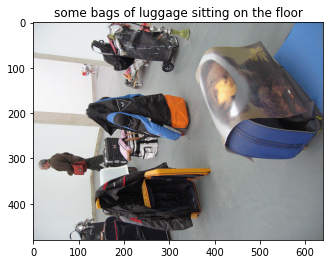

Caption length: tensor([10])


In [ ]:
data = CocoDataset(IMG_PATH, ANOT_PATH, transform = transforms.ToTensor(), 
                   target_transform = lambda x: torch.Tensor(x))

test_data = data[0]
plot_torch_img(opposite_split(test_data[1]), test_data[0])
print("Caption length:", test_data[-2])

In [ ]:
test_data[0].shape

torch.Size([3, 640, 425])

In [ ]:
data[1][0].shape

torch.Size([3, 334, 500])

In [ ]:
data[10][0].shape

torch.Size([3, 480, 640])

We have different sizes in our pictures dataset. In order to train a deep learning model, we will need to have equal input sizes of images, and we have to normalize our input data: images and encoded captions. The DataLoader class allows tu build efficient pipelines to apply transformations on torch tensors, and also builds automatically batches of data. We will use it for training and evaluation.

## Defining the model

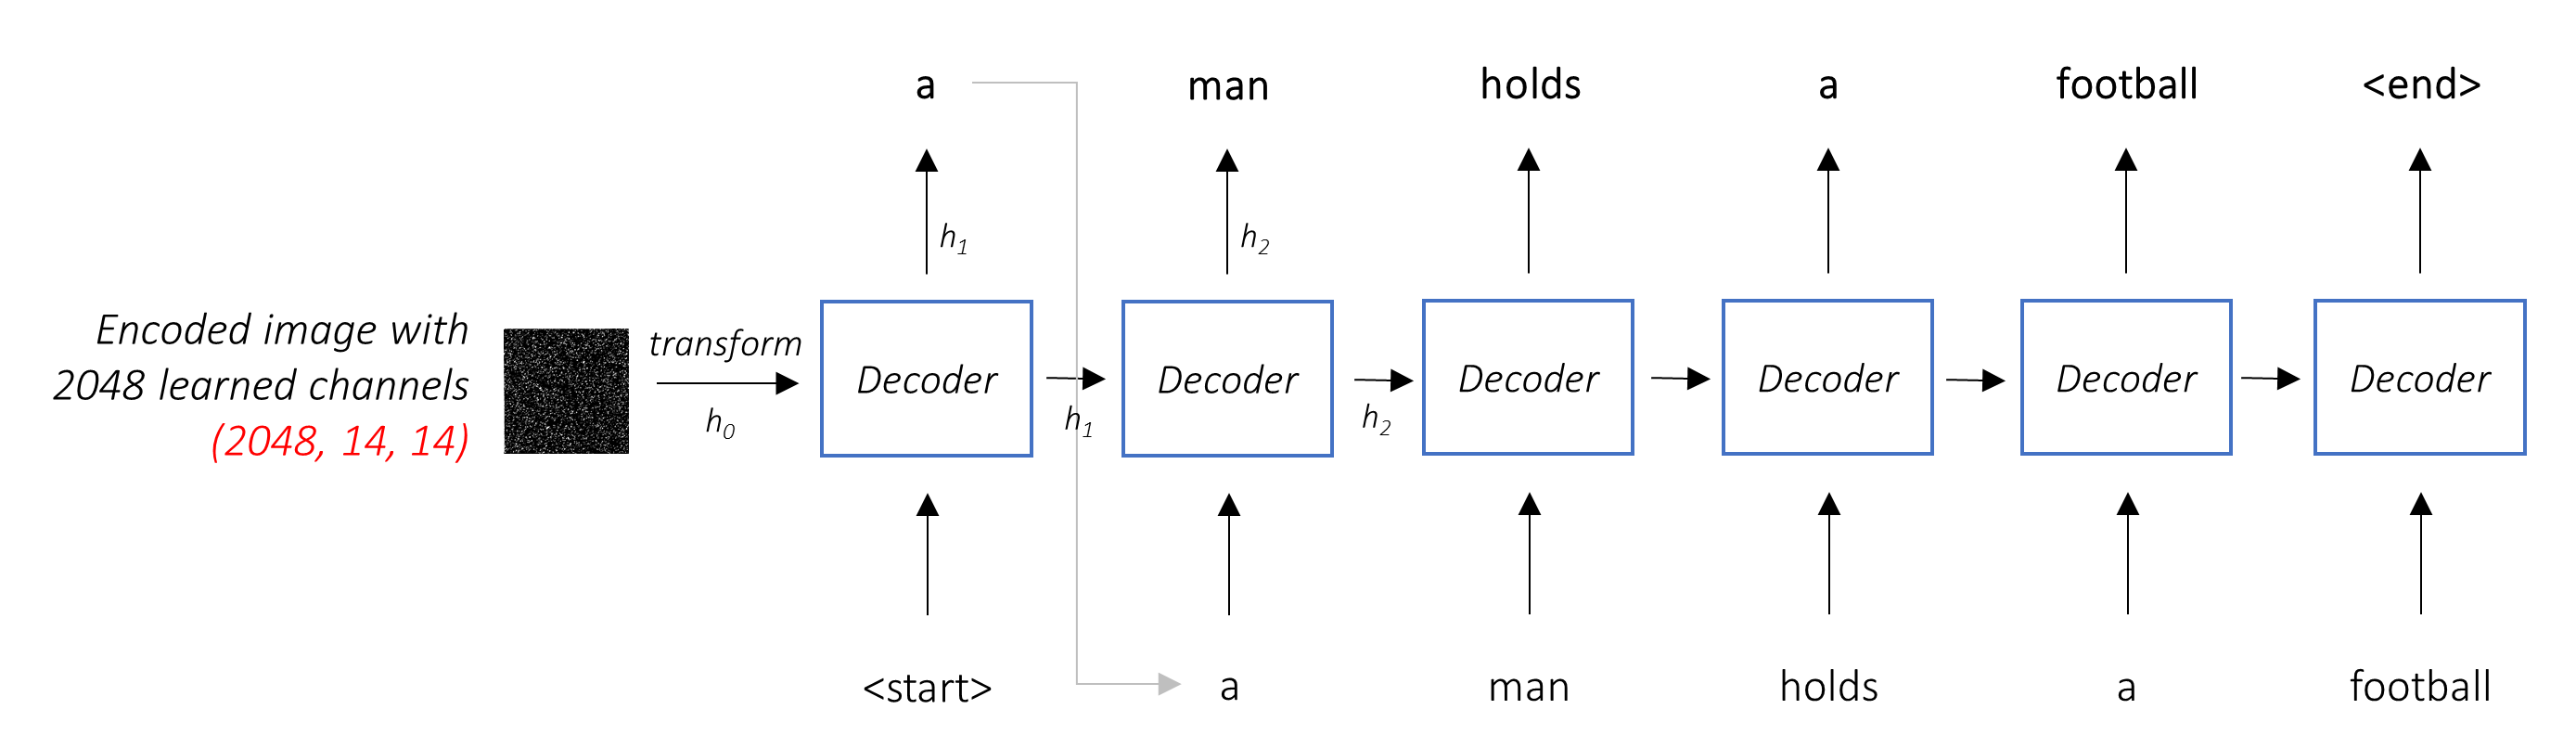

As depicted in the above figure, our first model is not difficult in nature. It is a Recurrent Neural Network, with the particularity that the initialized hidden state is the projection of the encoded image on a space of dimension `decoder_dim` (through a fully connected neural net). This initialization allows the RNN to decode each word conditionally to the "knowledge" of the image features. For the Decoder, we decided to use a Gated Recurrent Unit (https://arxiv.org/abs/1412.3555). For the Encoder, we propose two different convolutional architectures:
- A CNN with two layers of respectively 8 and 320 output channels with a $3\times 3$ kernel for each, both followed by a ReLU activation and MaxPooling. This is the class `ImageCapEncoder()`.
- A pre-trained convolutional neural network, the ResNet-101 (https://arxiv.org/abs/1512.03385) stored in the `PreTrainedEncoder()` class.

In this notebook, we will use the latter, for lighter backward computations (the weights are not updated in the pretrained encoder). But feel free to use the first for testing, you will just need to change the encoder_dim parameter and set it to 320.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import dill
import torchvision

class PreTrainedEncoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(PreTrainedEncoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101(pretrained=True)  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (the two last layers because we want the features)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        # We don't want our model to optimize the encoder
        for p in self.resnet.parameters():
            p.requires_grad = False

    def forward(self, input):
        out = self.resnet(input)  # dim = (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # dim = (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # dim = (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

class ImageCapEncoder(nn.Module): 
    def __init__(self, encoded_image_size=14):
        super(ImageCapEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3) # order: (nb_input channels, nb_output channels, kernel size)
        self.conv2 = nn.Conv2d(8, 320, 3)
        self.pool = nn.MaxPool2d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        
    def forward(self, input):
        output = self.pool(F.relu(self.conv1(input)))
        output = self.pool(F.relu(self.conv2(output)))
        output = self.adaptive_pool(output)
        output = output.permute(0, 2, 3, 1)               # dim = (batch_size, encoded_image_size, encoded_image_size, 2048)
        return output
    
class GRUDecoder(nn.Module):
    def __init__(self, embedding_dim, vocab_size, hidden_size, encoder_dim=320, dropout=0.2, device=device):
        super(GRUDecoder, self).__init__()
        self.embedding_dim = embedding_dim                # size of the embedding
        self.vocab_size = vocab_size                      # size of the captions' vocabulary
        self.hidden_size = hidden_size                    # the decoder size : number of cells in our RNN
        self.dropout = dropout
        self.device = device
        
        self.init_h = nn.Linear(encoder_dim, hidden_size)  # linear layer to find initial hidden state of GRU
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRUCell(embedding_dim, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)       # fully connected layer to output scores on vocabulary after GRU
        self.dropout = nn.Dropout(p=self.dropout)
        
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)                  # we apply a fully connected layer to obtain a vector of size
                                                           # (batch_size, decoder_dim)
        return h
    
    def forward(self, enc_out, captions, caption_lengths):  # enc_out : output of the encoder, captions : vector of words

        batch_size = enc_out.size(0)
        encoder_dim = enc_out.size(-1)
        vocab_size = self.vocab_size
        
        
        # ------------
        # ENCODER FEATURE: convolved image
        # ------------
        
        
        # Sort input data by decreasing lengths
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        enc_out = enc_out[sort_ind]
        captions = torch.tensor(captions[sort_ind]).to(torch.int64)
        
        # initialize the gru
        enc_out = enc_out.view(batch_size, -1, encoder_dim)                    # (batch_size, num_pixels, encoder_dim)
        hidden = self.init_hidden_state(enc_out)                               # mean over all the pixels : (batch_size, decoder_dim)
        decode_lengths = (caption_lengths - 1).flatten().tolist()
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(self.device) # Tensors for word prediction scores
        # output of predictions : (size batch_size, max caplength, vocab_size)
    
        # output size of the initialized hidden state : (batch_size, hidden_size)
        

        # ------------
        # CAPTION FEATURE: vector of length 51 for Coco dataset
        # ------------
        

        captions_embed = self.embedding(captions)         # size (batch_size, max_length, embedding_dim)
        captions_embed = F.relu(captions_embed)           # size (batch_size, max_length, embedding_dim)
        for t in range(max(decode_lengths)):              # we go through the sentence word by word
            batch_size_t = sum([l > t for l in decode_lengths])
            inp = captions_embed[:batch_size_t, t, :]     # size batch_size_t, embedding_dim
            hid = hidden[:batch_size_t]                   # size batch_size_t, hidden_size
            hidden = self.gru(inp, hid)                      
            # output size : batch_size_t, hidden_size
            preds = self.fc(self.dropout(hidden))         # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds

        return predictions, captions, decode_lengths
        

We can now check with a simple forward pass if our network works well. The output shape of our architecture should me a matrix of predictions, of size $(batch\_size, max\_seq\_len, vocab\_size)$. The value of $max\_seq\_len$ is variable, according to the batch of data we deal with. For each data point, meaning each set of image/caption, our network provides a vector of score for each word in the vocabulary in the image caption. This is a matrix of size $(max\_seq\_len, vocab\_size)$: at each emplacement (max_seq_len), we predict a vector of score for all the words in our vocabulary (vocab_size). Note that the Softmax is here not applied as it will be during the optimisation with `nn.CrossEntropyLoss()`.  

We can now check a forward pass with the first caption/image set of the COCO Dataset.

In [ ]:
word_map = data.encoder.word_map

encoder = ImageCapEncoder().to(device)
decoder = GRUDecoder(embedding_dim=5, 
                          vocab_size=len(word_map),
                          hidden_size=10).to(device)

# we check with the first image 

input = torch.unsqueeze(data[0][0],0).to(device)
img = encoder(input).to(device) # encoder step

On PyTorch, convolution result is size: $(N_{batch},Channels_{out},Height_{out},Width_{out})$. We permuted some shapes here.  
The encoder should output a tensor of size $(batch\_size, encoded\_image\_size, encoded\_image\_size, output\_conv)$. encoded_image_size is a parameter that is free to choose: it is a resize parameter to have convolved image with all equal squared size. In the original paper with visual attention, it is set to 14, so we also set it to 14. We also tried to design our own CNN, for academic purpose, but the optimisation took too long. This CNN from scratch is the `ImageCapEncoder()` class. Instead, we used a pretrained network for treating the images: the ResNet-101 network, based on residual skip connections between layers (https://arxiv.org/abs/1512.03385). In the original paper, the VGG-16 network is used (https://arxiv.org/abs/1409.1556).

In [ ]:
img.shape

torch.Size([1, 14, 14, 320])

We will now check our decoder output. This should return an output of size $(batch\_size, max\_seq\_len, vocab\_size)$.

In [ ]:
predictions, captions, decode_lengths = decoder(img, torch.unsqueeze(data[0][2],0).to(device), 
                                                torch.unsqueeze(data[0][3],0).to(device)) # decoder step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
predictions.shape

torch.Size([1, 12, 36303])

Taking the max should gives us the most probable word indexes for our input sentence. Of course, now, with no optimisation, this is random.

In [ ]:
_, preds = torch.max(predictions, dim=2)
preds

tensor([[26443, 32233, 19354, 20068, 13110,  9600,  4339, 16822, 20068, 32233,
         32233,   699]], device='cuda:0')

## Training and evaluation loop

The training loop is pretty simple. We use the DataLoader functionality of PyTorch to automatically generate batches of data (https://pytorch.org/docs/stable/data.html). We use it for the training and validation data. The loop is designed as follows:
- For each epoch:
  - we retrieve a batch of images/captions sets.
  - we pass the images through the CNN Encoder.
  - we pass the Encoder output and the ground-truth captions through the Decoder. We recall that the Decoder initialize the RNN with the projected convolved image on the space of dimension `decoder_dim`, and then decodes at each timestep using the previous hidden state. Decoder output has shape (batch_size, max_sequence_len, vocab_size).
  - we compute the loss between the obtained scores over the vocabulary for each word, and the target sentence. 
  - we perform backprop and update the weights.


In [ ]:
def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [ ]:
from torch import optim
word_map = data.encoder.word_map.items()

encoder = PreTrainedEncoder().to(device)
decoder = GRUDecoder(embedding_dim=512, 
                          vocab_size=len(word_map),
                          hidden_size=512,
                          dropout=0.5,
                          encoder_dim=2048).to(device)

decoder_lr = 4e-4
criterion = nn.CrossEntropyLoss().to(device)
encoder_optimizer = None
decoder_optimizer = optim.Adam(decoder.parameters(), lr=decoder_lr)

In [ ]:
from tqdm.notebook import tqdm

transformer = transforms.Compose([lambda x: x.resize((256,256)), transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])])
data_train = CocoDataset(IMG_PATH, ANOT_PATH, transform = transformer,
                     target_transform=lambda x: torch.LongTensor(x),
                     data_train=True)
data_val = CocoDataset(IMG_PATH, ANOT_PATH, transform = transformer,
                     target_transform=lambda x: torch.LongTensor(x),
                     data_train=False)
train_loader = DataLoader(data_train, batch_size=16, shuffle=True, num_workers=1)
val_loader = DataLoader(data_val, batch_size=16, shuffle=True, num_workers=1)
max_len = int(data.encoder.max_len)

word_map = data_train.encoder.word_map

def train(train_loader, val_loader, encoder, decoder, epochs=10, encoder_optimizer=encoder_optimizer,
          decoder_optimizer=decoder_optimizer,encoder_lr=1e-2, decoder_lr=1e-3):
  # track the losses at each batch
  losses_all = []
  losses_all_val = []
  losses_batch = []
  losses_batch_val = []

  for epoch in range(epochs):
    losses = []
    losses_val = []
    print('Training')
    for i, (imgs, _, caps, caplens, _) in enumerate(train_loader):

        # set up the training mode
        encoder.train()
        decoder.train()

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)
        
        # forward pass
        features = encoder(imgs)                                                              # encoder step: features has shape (batch_size, encoded_image_size, encoded_image_size, 2048)
        predictions, captions, decode_lengths = decoder(features, caps, caplens)              # decoder step: predictions has shape (batch_size, max_len, vocab_size)
        
        # extract the targets and the predictions
        targets = captions[:, 1:]                                                             # (batch_size, 50)
        scores, _, _, _ = pack_padded_sequence(predictions, decode_lengths, batch_first=True) # (size of all flattened 
                                                                                              # sentences in batch without pad,vocab_size)
        targets, _, _, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)    # (size of all flattened 
                                                                                              # sentences in batch without pad)
        
        # compute the loss
        loss = criterion(scores, targets)
        
        # Update the parameters in the optimizer
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()
 
        # track training loss
        losses.append(loss)
        losses_all.append(loss) 
    
        if i % print_freq == 0:
          print('Epoch: {epoch}\t'
                'Batch: {i}\t'
                'Loss: {loss:.4f}\t'
                'Top-5 Accuracy: {top5:.3f}\t'.format(epoch=epoch, i=i, loss=loss.item(), 
                                                          top5=accuracy(scores, targets, 5)))

    with torch.no_grad():
      print('Validation')
      for i, (imgs, _, caps, caplens, _) in enumerate(val_loader):

        # set up the training mode
        encoder.eval()
        decoder.eval()

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)
        
        # forward pass
        features = encoder(imgs)                                                              # encoder step: features has shape (batch_size, encoded_image_size, encoded_image_size, 2048)
        predictions, captions, decode_lengths = decoder(features, caps, caplens)              # decoder step: predictions has shape (batch_size, max_len, vocab_size)
        
        # extract the targets and the predictions
        targets = captions[:, 1:]                                                             # (batch_size, 50)
        scores, _, _, _ = pack_padded_sequence(predictions, decode_lengths, batch_first=True) # (shape of all flattened 
                                                                                              # sentences in batch without pad,vocab_size)
        targets, _, _, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)    # (shape of all flattened 
                                                                                              # sentences in batch without pad)
        
        # compute the loss
        loss = criterion(scores, targets)
 
        # track validation loss
        losses_val.append(loss)
        losses_all_val.append(loss) 
    
        if i % print_freq == 0:
          print('Epoch: {epoch}\t'
                'Batch: {i}\t'
                'Validation Loss: {loss:.4f}\t'
                'Top-5 Accuracy: {top5:.3f}\t'.format(epoch=epoch, i=i, loss=loss.item(), 
                                                          top5=accuracy(scores, targets, 5)))

    # compute the mean loss at each epoch
    losses_batch.append(torch.mean(torch.tensor(losses)))
    losses_batch_val.append(torch.mean(torch.tensor(losses_val)))
    torch.save(encoder.state_dict(),'/content/drive/MyDrive/encoder_net.pt')
    torch.save(decoder.state_dict(),'/content/drive/MyDrive/decoder_net.pt')

  return losses_batch, losses_all, losses_batch_val, losses_all_val

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map creation...
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map created!
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map creation...
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map created!
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


In [ ]:
print_freq = 100

losses_batch, losses_all, losses_batch_val, losses_all_val = train(train_loader=train_loader, val_loader=val_loader, 
                                                                   encoder=encoder, decoder=decoder, 
                                                                   epochs=30, encoder_optimizer=encoder_optimizer,
                                                                   decoder_optimizer=decoder_optimizer,encoder_lr=1e-2, 
                                                                   decoder_lr=4e-4)

Training


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 0	Batch: 0	Loss: 10.5661	Top-5 Accuracy: 0.000	
Epoch: 0	Batch: 100	Loss: 5.3632	Top-5 Accuracy: 38.728	
Epoch: 0	Batch: 200	Loss: 5.0335	Top-5 Accuracy: 42.408	
Epoch: 0	Batch: 300	Loss: 4.8027	Top-5 Accuracy: 45.055	
Epoch: 0	Batch: 400	Loss: 4.9637	Top-5 Accuracy: 42.541	
Validation
Epoch: 0	Batch: 0	Validation Loss: 4.5505	Top-5 Accuracy: 46.277	
Epoch: 0	Batch: 100	Validation Loss: 4.4348	Top-5 Accuracy: 51.429	
Epoch: 0	Batch: 200	Validation Loss: 4.8484	Top-5 Accuracy: 46.809	
Training
Epoch: 1	Batch: 0	Loss: 4.3436	Top-5 Accuracy: 52.525	
Epoch: 1	Batch: 100	Loss: 4.3082	Top-5 Accuracy: 52.406	
Epoch: 1	Batch: 200	Loss: 3.6204	Top-5 Accuracy: 57.377	
Epoch: 1	Batch: 300	Loss: 4.1842	Top-5 Accuracy: 55.615	
Epoch: 1	Batch: 400	Loss: 3.8614	Top-5 Accuracy: 56.452	
Validation
Epoch: 1	Batch: 0	Validation Loss: 3.4691	Top-5 Accuracy: 63.736	
Epoch: 1	Batch: 100	Validation Loss: 4.3022	Top-5 Accuracy: 52.356	
Epoch: 1	Batch: 200	Validation Loss: 3.4557	Top-5 Accuracy: 59.172	

We can have a look at the loss evolution during the training.

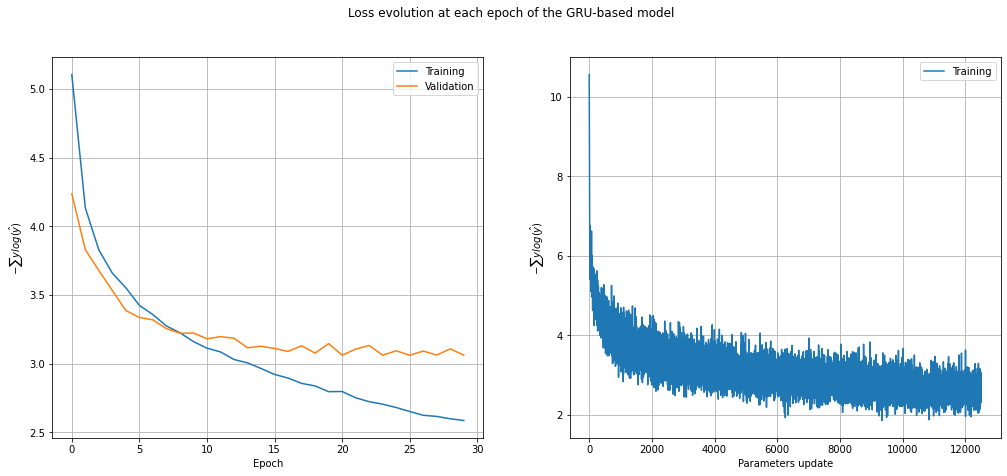

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(17,7))
plt.suptitle('Loss evolution at each epoch of the GRU-based model')
axes[0].grid()
axes[1].grid()
axes[0].set_xlabel('Epoch')
axes[1].set_xlabel('Parameters update')
axes[0].set_ylabel('$-\sum ylog(\hat{y})$')
axes[1].set_ylabel('$-\sum ylog(\hat{y})$')
axes[0].plot(losses_batch, label='Training')
axes[1].plot(losses_all, label='Training')
axes[0].plot(losses_batch_val, label='Validation')
axes[0].legend()
axes[1].legend()
plt.savefig('/content/drive/MyDrive/grulosses.jpg')
plt.show()

## Inference with beam search

The beam search algorithm is the following one.
- At the first decode step, consider the top k candidates.
- Generate k second words for each of these k first words.
- Choose the top k [first word, second word] combinations considering additive scores.
- For each of these k second words, choose k third words, choose the top k [first word, second word, third word] combinations.
- Repeat at each decode step.
- After k sequences terminate, choose the sequence with the best overall score.

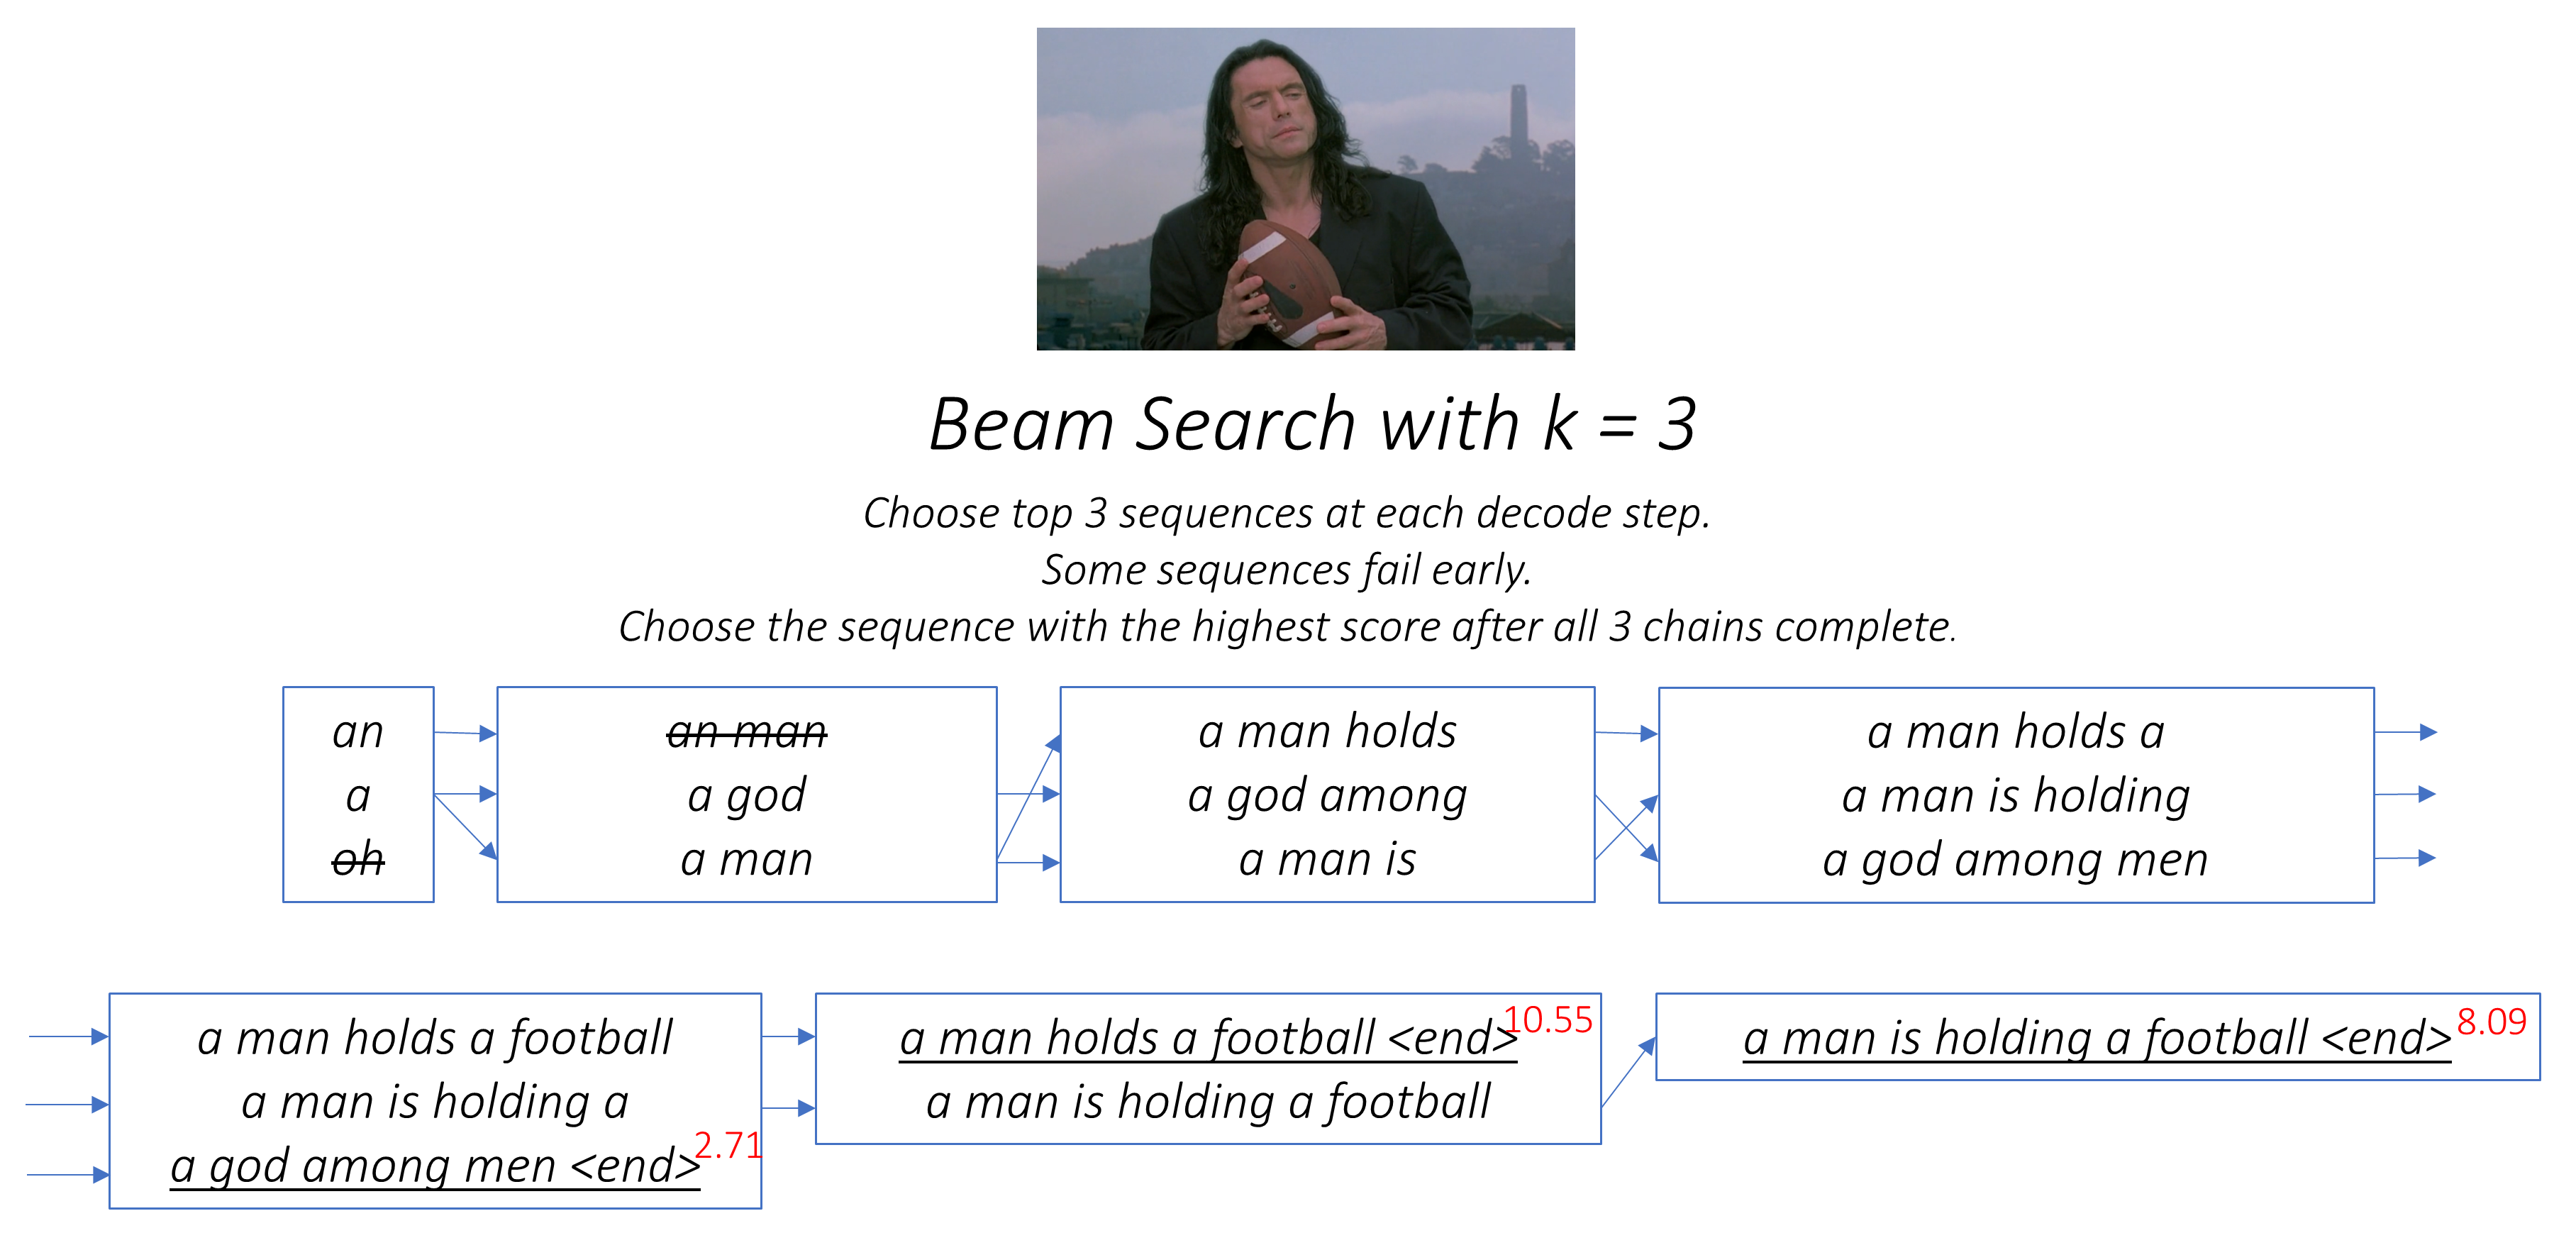

In [ ]:
word_map = data.encoder.word_map.items()

encoder = PreTrainedEncoder().to(device)
decoder = GRUDecoder(embedding_dim=512, 
                          vocab_size=len(word_map),
                          hidden_size=512,
                          dropout=0.5,
                          encoder_dim=2048).to(device)

encoder.load_state_dict(torch.load('/content/drive/MyDrive/encoder_net.pt'))
decoder.load_state_dict(torch.load('/content/drive/MyDrive/decoder_net.pt'))

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


<All keys matched successfully>

In [ ]:
def caption_image_beam_search(encoder, decoder, image_path, word_map, device, beam_size=3):
    """ Reads an image and captions it with beam search.
        :param encoder: encoder model
        :param decoder: decoder model
        :param image_path: path to image
        :param word_map: word map
        :param beam_size: number of sequences to consider at each decode-step
        :return caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = np.array(Image.open(image_path).convert('RGB').resize((256, 256)))
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([transforms.ToTensor(), normalize])
    image = transform(img).to(device)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        h = decoder.gru(embeddings, h)  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            print("reached")
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]

    return seq, img

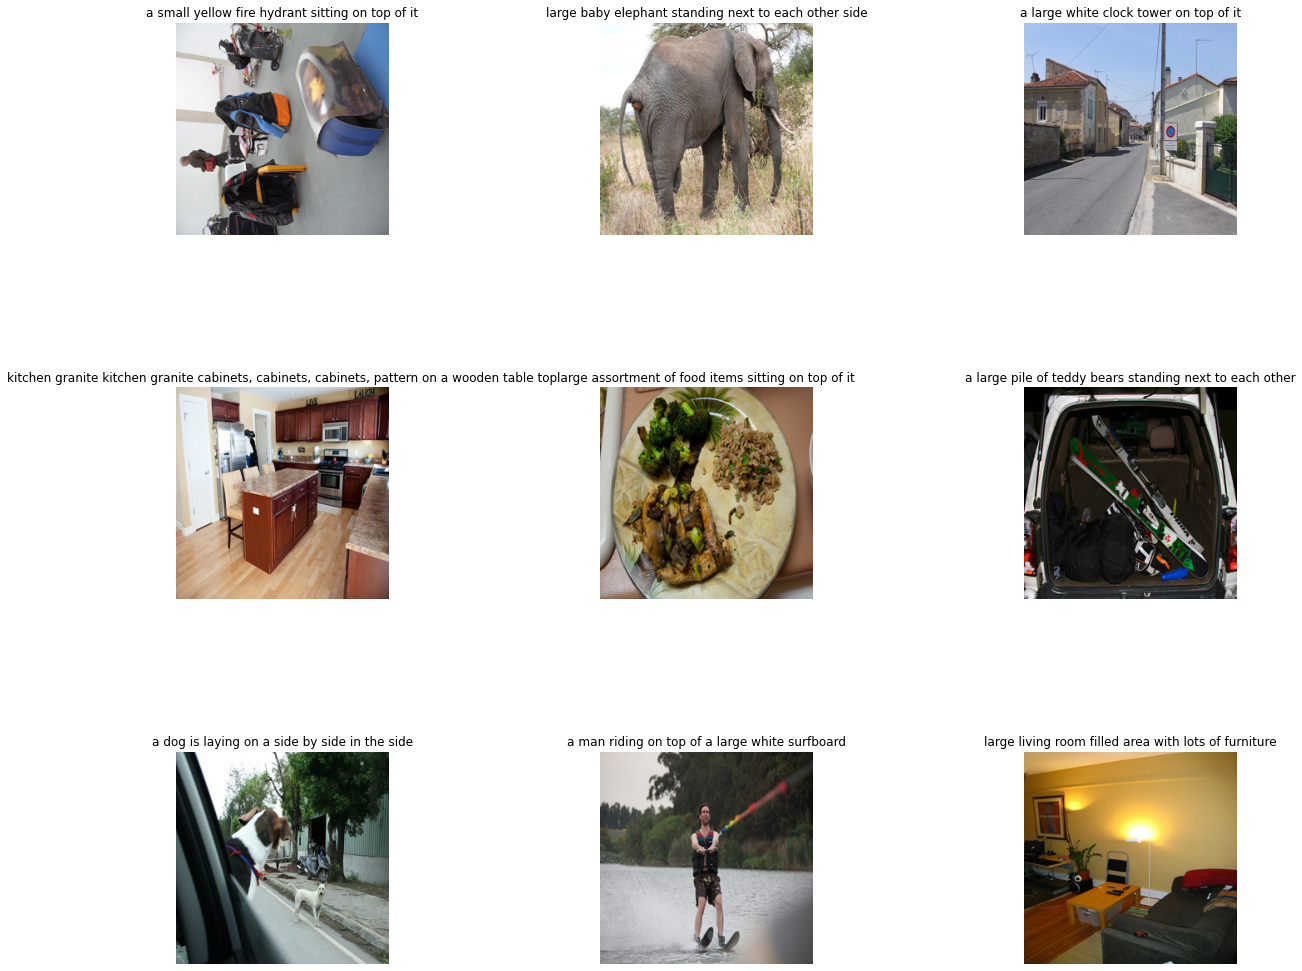

In [ ]:
img_path = ["/content/train2017/" + i for i in os.listdir("/content/train2017/")]
inv_wordmap = {x:i for i,x in data.encoder.word_map.items()}

f, axs = plt.subplots(3,3,figsize=(19,19))
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)

for i in range(9):
  seq, img = caption_image_beam_search(encoder, decoder, img_path[i],
                                               data.encoder.word_map, device=device,
                                               beam_size=5)
  pred = [inv_wordmap[k] for k in seq[1:-1]]
  axs[i % 3,i // 3].imshow(img)
  axs[i % 3,i // 3].set_title(opposite_split(pred))
  axs[i % 3,i // 3].axis('off')
  
plt.savefig("cap_generation_gru.jpg")

The obtained captions are really different in terms of quality. Some of them are pretty accurate (the last one, the one in the middle), but most of them contain single elements of the images without creating a gramatically coherent sum-up of them. 

## Evaluation with Bleu score

BLEU score was introduced in the paper of Papiani et al. in 2002 (https://www.researchgate.net/publication/2588204_BLEU_a_Method_for_Automatic_Evaluation_of_Machine_Translation).

$$
p_n = \frac{\sum_{C \in\{\text { Candidates }\}} \sum_{n-g r a m \in C} \text { Count }_{\text {clip }}(n \text { -gram })}{\sum_{C^{\prime} \in\{\text { Candidates }\}} \sum_{n \text { -gram }^{\prime} \in \mathcal{C}^{\prime}} \operatorname{Count}\left(n-g \mathrm{ram}^{\prime}\right)} \\
\begin{array}{c}
\mathrm{BP}=\left\{\begin{array}{ll}
1 & \text { if } c>r \\
e^{(1-r / c)} & \text { if } c \leq r
\end{array}\right. \\
\mathrm{BLEU}=\mathrm{BP} \cdot \exp \left(\sum_{n=1}^{N} w_{n} \log p_{n}\right)
\end{array}
$$

with $w_{n}=1 / N$ are weights summing to one, $r$ is the reference corpus length, $c$ the candidate corpus length. 
In the following code, we compute the average BLEU sentence-to-sentence score on each batch of the validation data. That is, for each batch, we compute all the BLEU scores of the predictions and targets, we average them, and we finally take the mean of all this list. This is an "average of average". In the next notebook, with the attention mechanism, we'd rather compute the BLEU-4 score, that is the BLEU score between one prediction and the corpus of 4 original captions for each image that are provided in the database. Hence the scores will be less satisfying than for the current approach.

In [ ]:
import nltk
bleusall = []

for i, (imgs, _, caps, caplens, _) in enumerate(val_loader):

        # set up the training mode
        encoder.eval()
        decoder.eval()

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)
        
        # forward pass
        features = encoder(imgs)                                                 # encoder step
        predictions, captions, decode_lengths = decoder(features, caps, caplens) # decoder step
        
        # extract the targets and the predictions
        targets = captions[:, 1:][:,:max(decode_lengths)]
        _, preds = torch.max(predictions, dim=2)

        # retrieve the sentences
        tar = [[inv_wordmap[k.item()] for k in targets[i,:].cpu()] for i in range(len(targets))]
        pred = [[inv_wordmap[k.item()] for k in preds[i,:].cpu()] for i in range(len(preds))]
        bleus = [nltk.translate.bleu_score.sentence_bleu(tar[j], pred[j]) for j in range(len(tar))]
        bleusall.append(np.mean(bleus))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print('Average BLEU score over validation batches (avg of avg):',np.mean(bleusall))

Average BLEU score over validation batches (avg of avg): 0.5107988413325383
